# DATA5000 Workshop #2

## This Python notebook has different sections:

### (1) steps through the basics of machine learning

### (2) the forecasting notebook can be obtained here: https://colab.research.google.com/github/data-5000/data5000/blob/main/week_2/week_2_2_notebook.ipynb


## Install SHAP for Explainable ML

In [2]:
%pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 12.1 MB/s eta 0:00:00


In [3]:
%pip install econml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: shap
    Found existing installation: shap 0.46.0
    Uninstalling shap-0.46.0:
      Successfully uninstalled shap-0.46.0


## Import Python support libraries

In [4]:
# core python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# machine learning libraries
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import GridSearchCV
# import SHAP explainable ML
import shap

# instruct mat plot library to show visuals inline
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## fetch dataset: AMES Housing

In [5]:
from sklearn.datasets import fetch_openml

ames_housing = fetch_openml(name="house_prices", as_frame = True)

The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.


## Convert AMES Housing into a dataframe

In [6]:
ames = ames_housing.data
ames

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


In [7]:
ames['Alley']

,Alley
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
1455,NaN
1456,NaN
1457,NaN
1458,NaN


# Data Pre-processing "pipeline"

In [8]:
ames_Xy = (

    # ames dataframe
    ames

    # set the SalePrice as the target or outcome
    .assign(SalePrice = ames_housing.target)

    # set Id as index
    .set_index('Id')
     # drop outliers with missing detail in this column
    .loc[
        lambda df: df['MasVnrType'].notna()
    ]

    # drop outlier with missing electrical row
    .loc[
        lambda df: df['Electrical'].notna()
    ]
    .assign(

        # add interpretable year columns
        AgeAtSale = lambda df: df['YrSold'].sub(df['YearBuilt']),

        # clip lower for outlier
        YearsSinceRemodel = lambda df: df['YrSold'].sub(df['YearRemodAdd']).clip(lower = 0),

        # has deck binary
        HasDeck = lambda df: df['WoodDeckSF'].gt(0).map(int),

        # has porch binary
        HasPorch = lambda df:
        df[['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']]
        .gt(0)
        .max(axis = 1)
        .map(int),

        # has fireplace binary
        HasFireplace = lambda df: df['Fireplaces'].clip(upper = 1).map(int),

        # has fence binary
        HasFence = lambda df: df['Fence'].notna().map(int)
    )

    # drop some columns
    .drop(
        columns = [
            'GarageYrBlt', 'YearBuilt', 'YrSold', 'YearRemodAdd',
            'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
            'FireplaceQu', 'Fireplaces',
            'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
            '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'PoolArea'
        ]
    )

    # fill missing values
    .assign(LotFrontage = lambda df: df['LotFrontage'].fillna(0))

    # rest of missing values are in categorical columns, so fill with NA category
    .fillna('NA')

    # add constant column for when performing OLS
    .assign(Intercept = 1)
)

ames_Xy

,MSSubClass,MSZoning,LotFrontage,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleType,SaleCondition,SalePrice,AgeAtSale,YearsSinceRemodel,HasDeck,HasPorch,HasFireplace,HasFence,Intercept
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,208500,5,5,0,1,0,0,1
2,20,RL,80.0,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,...,WD,Normal,181500,31,31,1,0,1,0,1
3,60,RL,68.0,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,...,WD,Normal,223500,7,6,0,1,1,0,1
4,70,RL,60.0,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,...,WD,Abnorml,140000,91,36,0,1,1,0,1
5,60,RL,84.0,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,...,WD,Normal,250000,8,8,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,175000,8,7,0,1,1,0,1
1457,20,RL,85.0,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,210000,32,22,1,0,1,1,1
1458,70,RL,66.0,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,266500,69,4,0,1,1,1,1


## Save pre-processed dataset as CSV format data file

In [9]:
ames_Xy.to_csv('ames_house_price.csv') # read_csv()

In [10]:
ames_Xy.dtypes

,0
MSSubClass,int64
MSZoning,object
LotFrontage,float64
Street,object
Alley,object
...,...
HasDeck,int64
HasPorch,int64
HasFireplace,int64
HasFence,int64


## Identify categorical data

In [11]:
# identify categorical columns for one hot encoding
categorical = list(
    ames_Xy
    .apply(lambda series: series.dtype)
    .loc[
        lambda df: df.eq('object')
    ]
    .index
) + ['MSSubClass']

In [12]:
categorical

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'MSSubClass']

## Convert categorical data into numerical equivalent representation: in this case we use Pandas "Get Dummies" utility to convert categorical to a series of 0s and 1s.

## This approach is called "one-hot encoding"

In [13]:
# drop the target from the data features
X = ames_Xy.drop(columns = 'SalePrice')

In [14]:
# one hot encoding
X_onehot = (
    X
    .pipe(pd.get_dummies, prefix_sep = '_OHE_', columns = categorical, dtype='uint8')
)


In [15]:
X_onehot

,LotFrontage,OverallQual,OverallCond,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,...,MSSubClass_OHE_60,MSSubClass_OHE_70,MSSubClass_OHE_75,MSSubClass_OHE_80,MSSubClass_OHE_85,MSSubClass_OHE_90,MSSubClass_OHE_120,MSSubClass_OHE_160,MSSubClass_OHE_180,MSSubClass_OHE_190
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,7,5,1710,1,0,2,1,3,1,...,1,0,0,0,0,0,0,0,0,0
2,80.0,6,8,1262,0,1,2,0,3,1,...,0,0,0,0,0,0,0,0,0,0
3,68.0,7,5,1786,1,0,2,1,3,1,...,1,0,0,0,0,0,0,0,0,0
4,60.0,7,5,1717,1,0,1,0,3,1,...,0,1,0,0,0,0,0,0,0,0
5,84.0,8,5,2198,1,0,2,1,4,1,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,62.0,6,5,1647,0,0,2,1,3,1,...,1,0,0,0,0,0,0,0,0,0
1457,85.0,6,6,2073,1,0,2,0,3,1,...,0,0,0,0,0,0,0,0,0,0
1458,66.0,7,9,2340,0,0,2,0,4,1,...,0,1,0,0,0,0,0,0,0,0


## Set the outcome or target variable

In [16]:
y = ames_Xy['SalePrice']

## Create a linear regression model

In [17]:
model = sm.OLS(y, X_onehot)

# Fitting a model (training)

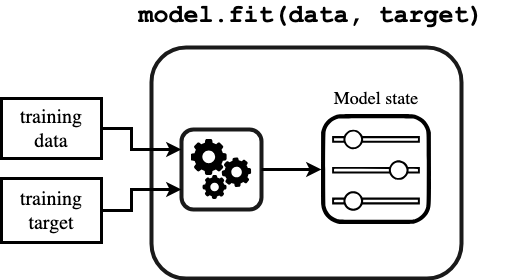

In [18]:
# train the linear regression model with fit
results = model.fit()

## The metric that we are interested in the "adjusted R-squared" value - this tells us, between 0 and 100 (percent), what proportion of the outcome could be explained by the correlation with the predictor variables (data features).

## Since this is a multivariate machine learning problem, R-squared (only makes sense for univariate cases) is not an appropriate measure.

In [19]:
# show results of training (fit)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     59.41
Date:                Sun, 15 Sep 2024   Prob (F-statistic):               0.00
Time:                        06:11:44   Log-Likelihood:                -16565.
No. Observations:                1451   AIC:                         3.362e+04
Df Residuals:                    1206   BIC:                         3.491e+04
Df Model:                         244                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
LotFrontage                   9.1690     24.385      0.376      0.707     -38.674      57.012
OverallQual                6443.4507   1098.337      5.867      0.000    4288.587    8598.315
OverallCond                5761.3467    921.305      6.253      0.000    3953.808    7568.885
GrLivArea                    71.2724      3.926     18.155      0.000      63.570      78.975
BsmtFullBath               7808.0939   1862.581      4.192      0.000    4153.836    1.15e+04
BsmtHalfBath               2704.3964   3161.287      0.855      0.392   -3497.837    8906.630
FullBath                   4353.2284   2358.076      1.846      0.065    -273.159    8979.616
HalfBath                   1125.2313   2213.287      0.508      0.611   -3217.089    5467.552
BedroomAbvGr              -4678.0376   1473.399     -3.175      0.002   -7568.747   -1787.328
KitchenAbvGr              -1.089e+04   6648.976     -1.639      0.102   -2.39e+04    2150.473
TotRmsAbvGrd               1013.7051   1016.102      0.998      0.319    -979.818    3007.228
GarageCars                 8663.3405   1708.010      5.072      0.000    5312.340     1.2e+04
MiscVal                       9.0392      6.684      1.352      0.177      -4.074      22.153
MoSold                     -510.0946    260.244     -1.960      0.050   -1020.675       0.486
AgeAtSale                  -305.4555     85.143     -3.588      0.000    -472.501    -138.410
YearsSinceRemodel           -27.7465     58.392     -0.475      0.635    -142.308      86.815
HasDeck                    1621.8650   1585.671      1.023      0.307   -1489.115    4732.845
HasPorch                   1870.3246   1739.962      1.075      0.283   -1543.365    5284.014
HasFireplace               2375.0085   1818.079      1.306      0.192   -1191.941    5941.958
HasFence                  -5877.2263   2031.768     -2.893      0.004   -9863.419   -1891.033
Intercept                 -8887.1036   3683.133     -2.413      0.016   -1.61e+04   -1661.044
MSZoning_OHE_C (all)      -2.978e+04   8731.959     -3.411      0.001   -4.69e+04   -1.27e+04
MSZoning_OHE_FV            1.271e+04   6497.547      1.957      0.051     -33.757    2.55e+04
MSZoning_OHE_RH            4234.7895   6421.424      0.659      0.510   -8363.614    1.68e+04
MSZoning_OHE_RL            4630.5784   3487.791      1.328      0.185   -2212.233    1.15e+04
MSZoning_OHE_RM            -682.4301   3937.317     -0.173      0.862   -8407.183    7042.323
Street_OHE_Grvl           -8776.6589   6992.025     -1.255      0.210   -2.25e+04    4941.225
Street_OHE_Pave            -110.4448   6575.318     -0.017      0.987    -1.3e+04    1.28e+04
Alley_OHE_Grvl            -1810.1857   3604.374     -0.502      0.616   -8881.726    5261.355
Alley_OHE_NA              -4693.0936   2616.409     -1.794      0.073   -98

## Data Splitting

### It is mandatory to split the dataset into:

### (1) training (machine learning)
### (2) testing (making the actual prediction)

In [20]:
# Split data into train and test
from sklearn.model_selection import train_test_split

x_train_onehot, x_test_onehot, x_train, x_test, y_train, y_test = train_test_split(
    X_onehot, X, y, test_size=0.2, random_state=123
)

# LightGBM Machine Learning Algorithm

# https://github.com/microsoft/LightGBM/tree/master/examples/python-guide

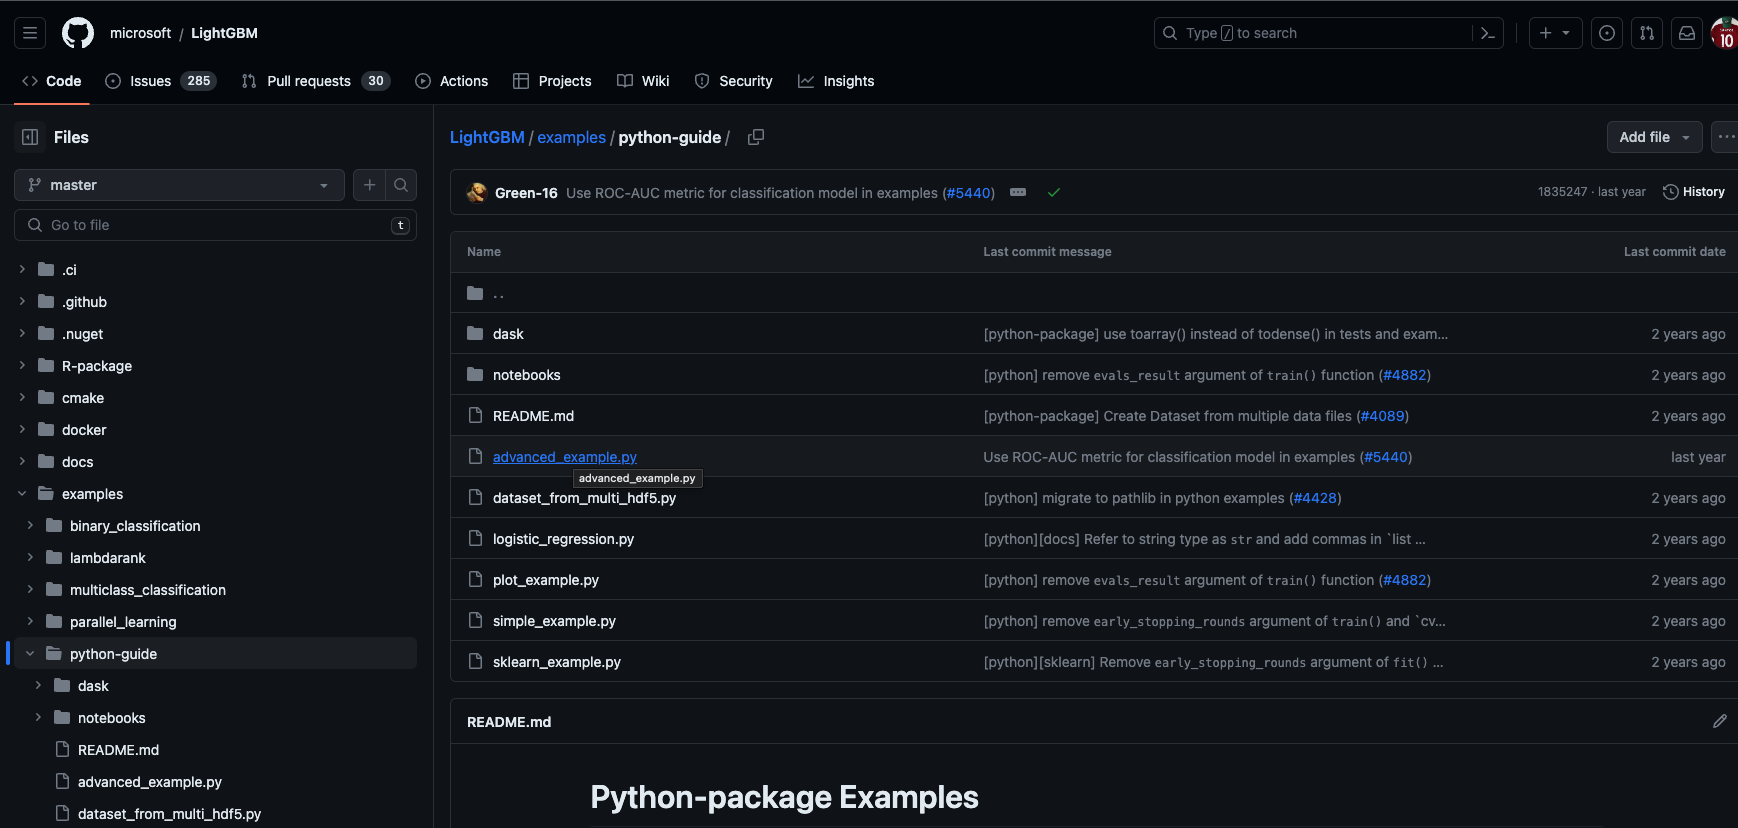

## Create LightGBM model

In [21]:
light_gbm_model = LGBMRegressor()

In [22]:
param_grid = {"learning_rate": [0.1, 0.05, 0.01], "max_depth": [3, 5, 10]}

In [23]:
search = GridSearchCV(light_gbm_model, param_grid, n_jobs=-1)

# Fitting the model

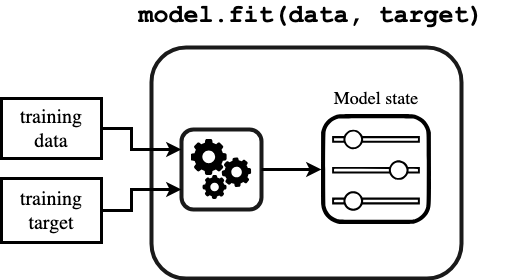

In [24]:
# train lightGBM model
search.fit(x_train_onehot, y_train)

# display results of training
print("Best estimator: ", search.best_params_)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 1160, number of used features: 186
[LightGBM] [Info] Start training from score 180622.996552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

## Predict on test dataset

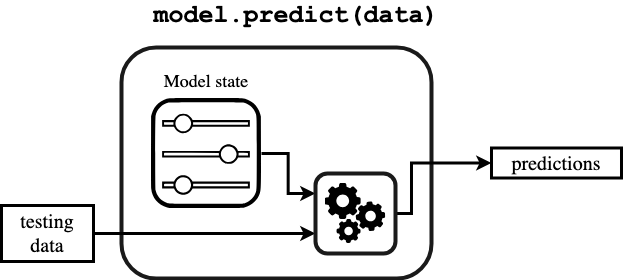

In [25]:
predictions = search.predict(x_test_onehot)

In [26]:
predictions

array([138128.36974778, 227123.37086785, 525580.03249479, 228821.27497538,
       148425.79343663, 176642.69369521,  88762.53701858, 114036.93552061,
        91654.24148131, 134805.302777  , 124344.92416926, 185626.84188108,
        91228.10172402, 149106.6891525 , 225564.64708797, 373180.91493788,
       117219.08745416, 142376.37327972, 142930.40421029, 134531.91454627,
       181778.88269412, 190979.51006485, 190942.32198801, 144656.21771585,
       352067.94997048, 176165.08711846, 148328.27707346,  98146.06723987,
       113102.25088507, 119819.40600867, 143893.88718028, 173506.71299582,
       220079.63939521, 186364.66251316, 237643.29162032, 174153.07009517,
       177860.72612904, 132668.35064881,  83624.97351747, 182127.74096663,
       148444.80310788, 158037.23255649,  85404.60226515, 197400.98006626,
       107236.51542624, 110328.80658101, 142305.69913868, 115295.30472345,
       139399.48221055, 122952.57375042, 141229.06419431, 153236.13063505,
        99457.2772324 , 3

# Model score (accuracy)

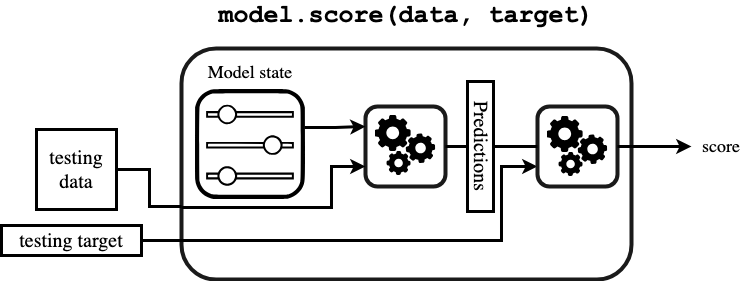

In [27]:
print("Test set score: ", search.best_estimator_.score(x_test_onehot, y_test))

Test set score:  0.8692825143979841


In [28]:
fitted_model = search.best_estimator_

In [29]:
fitted_model

LGBMRegressor(max_depth=10)

# Explainable Machine Learning
## How did LightGBM learn the features for houses (predictors) and the outcomes (house price)?

# SHAP: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

## We use SHAP to create a waterfall chart

## About SHAP masks: https://shap.readthedocs.io/en/latest/generated/shap.maskers.Independent.html



In [30]:
# use interventional approach
independent_data_sample_mask = shap.maskers.Independent(x_train_onehot, max_samples=1000)

In [31]:
independent_data_sample_mask

## Use SHAP Tree Explainer



In [32]:
explainer = shap.TreeExplainer(
    fitted_model,
    data=independent_data_sample_mask,
    feature_names=X_onehot.columns
)

In [33]:
shap_values = explainer(x_test_onehot)

 97%|=================== | 283/291 [00:21<00:00]       

In [34]:
shap_values

.values =
array([[-3.72192765e+02, -1.70844396e+04,  4.73398300e+03, ...,
         2.80754844e+01,  0.00000000e+00,  0.00000000e+00],
       [-6.36501968e+02,  5.49295024e+03,  2.13039073e+03, ...,
         4.29864702e+01,  0.00000000e+00,  0.00000000e+00],
       [ 1.79785145e+04,  1.19150224e+05, -1.34898661e+03, ...,
         2.99582177e+01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 7.43709909e+02, -1.42433884e+04,  2.18303834e+03, ...,
         3.48768830e+01,  0.00000000e+00,  0.00000000e+00],
       [-2.81009665e+02,  5.27673876e+03, -2.39252445e+03, ...,
         5.24705572e+01,  0.00000000e+00,  0.00000000e+00],
       [ 2.09806609e+03,  3.78627795e+04, -2.29305546e+03, ...,
         6.01961804e+01,  0.00000000e+00,  0.00000000e+00]])

.base_values =
array([180685.88841229, 180685.88841229, 180685.88841229, 180685.88841229,
       180685.88841229, 180685.88841229, 180685.88841229, 180685.88841229,
       180685.88841229, 180685.88841229, 180685.88841229, 180685.88

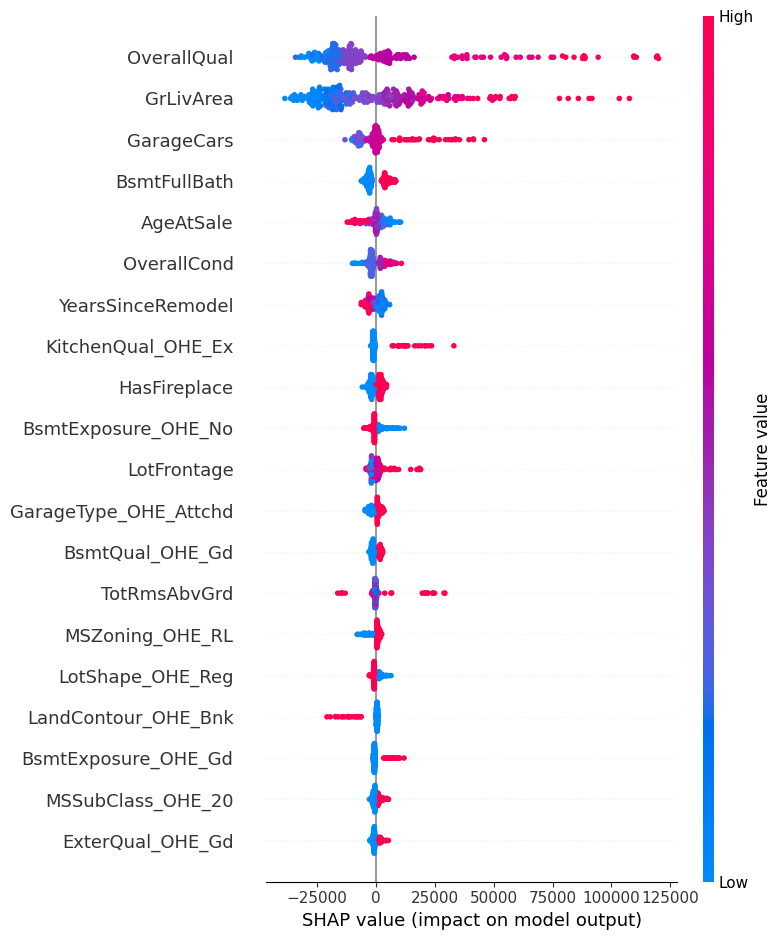

In [35]:
# plot the feature importance
shap.summary_plot(shap_values, x_test_onehot)

# Using Cross Validation (in place of data splitting)